# <span style="color:red"> Main Modelling - Decision Tree - Gridsearch </span>
* read in pickle
* keep 3 translators
* final selected features based on initial analysis with logistic regression
* drop 'A Wild Sheep Chase' due to unique text
* run decision tree grid search with initial analysis


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import label_binarize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load the dataframe containing text chunks and related variables

In [3]:
in_full_path = '../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [4]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(5253, 141)

In [6]:
# df.columns

### Drop 'A Wild Sheep Chase' 

In [7]:
df = df[df['book_title'] != 'A Wild Sheep Chase']

### Check the baseline

In [8]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.4364282726892514

### Select Predictor Variables

In [9]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [10]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=True, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

### Set Target and Predictor variables

In [11]:
X = df[predictor_cols]
y = df['trans_code']

### Make Train Test Split with stratify on y

In [12]:
# stratify based on your target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

### Standardise the predictor variables

In [13]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

### Decision Tree classification with cross validation

In [17]:
# gridsearch params
dtr_params = {
    'max_depth': list(range(1, 15))+[None],
    'max_features': [None, 1, 3, 5, 7],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01],
    'criterion': ['gini', 'entropy']
}


# set the gridsearch
model = DecisionTreeClassifier()
dt_gs_01 = GridSearchCV(model, 
                        dtr_params, 
                        cv=5, verbose=1, 
                        n_jobs=2)

dt_gs_01.fit(X_train, y_train)

Fitting 5 folds for each of 6600 candidates, totalling 33000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 460 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 4176 tasks      | elapsed:   41.6s
[Parallel(n_jobs=2)]: Done 8648 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 14248 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 23860 tasks      | elapsed:  4.3min
[Parallel(n_jobs=2)]: Done 32628 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 33000 out of 33000 | elapsed:  6.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                  

In [18]:
def dt_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
    print('ROC-AUC score on the test set:')
    
    # store the grid search results as a dictionary
    y_bin = label_binarize(y_test, model.classes_)
    for i, class_ in enumerate(model.classes_):
        print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
    results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
    results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
    results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [19]:
dt_gs_01_results = dt_gridsearch_score(dt_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_split': 50}
Best estimator mean cross validated training score:
0.5495424836601307
Best estimator score on the full training set:
0.690718954248366
Best estimator score on the test set:
0.5506792058516197
ROC-AUC score on the test set:
Class 0: 0.66
Class 1: 0.74
Class 2: 0.73


#### DT does not do as well as logistic regression or KNN for the moment

### Save the model

In [20]:
# set the output path and name
out_path = '../../../Documents/murakami/pkl_models/'
out_name = 'dt_gs_01_ns'
out_full_path = out_path + out_name + '.pkl'

# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(dt_gs_01, fp)

### Confusion Matrix

In [22]:
predictions = dt_gs_01.predict(X_test)

In [23]:
conmat = confusion_matrix(
    y_test, predictions, labels=[0, 1, 2])

confusion = pd.DataFrame(conmat, index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                         columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel'])
confusion

,predicted birnbaum,predicted rubin,predicted gabriel
actual birnbaum,86,101,71
actual rubin,60,273,85
actual gabriel,55,58,168


* The confusion matrix shows that although dtr does a bit better than knn for birnbaum and gabriel it does significantly worse for rubin than the other models 

### Classification Report

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.43      0.33      0.37       258
           1       0.63      0.65      0.64       418
           2       0.52      0.60      0.56       281

    accuracy                           0.55       957
   macro avg       0.53      0.53      0.52       957
weighted avg       0.54      0.55      0.54       957



### Feature importances

Decision trees can give us feature importances. The higher the number the more important the predictor was for deciding splits at nodes.
Technically, "the importance of a feature is computed as the (normalized) total reduction of the
criterion brought by that feature." 

That means a feature is more important 

- if it is used in many different nodes, 
- if the difference in the measures of Gini or entropy are before and after the split is high

Feature importances are normalized in the sense of summing up to one.

In [25]:
# feature importances
feature_importances = dt_gs_01.best_estimator_.feature_importances_
df_feat_imp = pd.DataFrame(list(zip(X_test.columns, dt_gs_01.best_estimator_.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

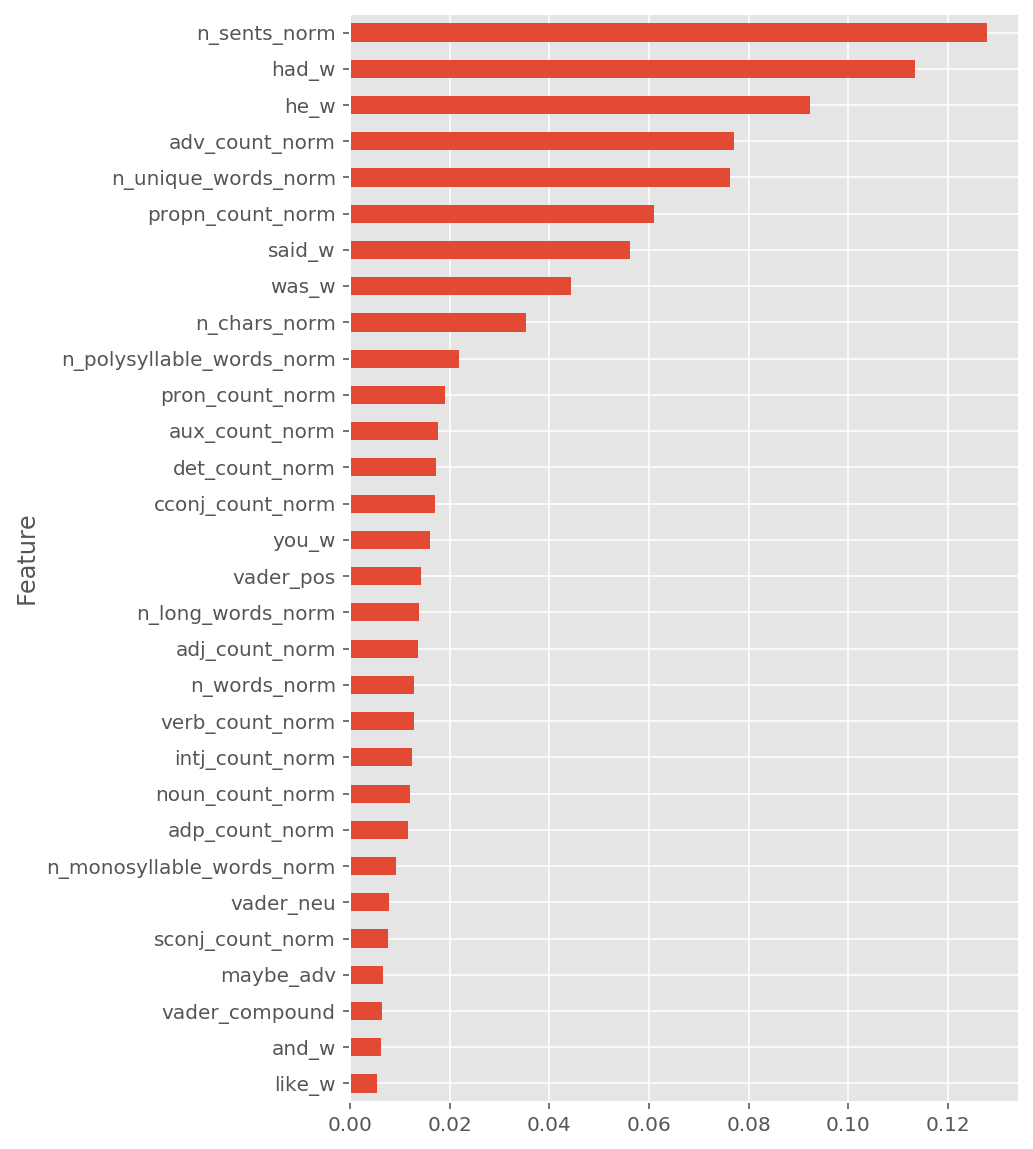

In [30]:
df_feat_imp.set_index('Feature')['Importance'].sort_values(ascending=True).tail(30) \
                .plot(kind='barh', figsize=(6,10))
plt.show()